## Notebook to prep expression data
detection, sex check, normalization, and covariates

#### import libraries and notebook variables

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
import random
from umap import UMAP
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
import threading

In [2]:
# parameter variables
cohort = 'ppmi'
amp_abbr = 'PP'
version = 'amppdv1'
tissue = 'wb'
visit = 6
visit_name = 'SVM6T1'

In [3]:
# naming
cohort_version = f'{cohort}.{version}'
cohort_build = f'{cohort}.{tissue}{visit}'

# directories
wrk_dir = f'/labshare/raph/eqtl/{cohort}'
geno_dir = f'{wrk_dir}/genotypes'
expr_dir = f'{wrk_dir}/expression'
info_dir = f'{wrk_dir}/sample_info'

# input files
src_expression_matrix = f'/labshare/raph/datasets/amppd/expression/{amp_abbr}.{visit_name}.genes.csv'
src_sample_info = '/labshare/raph/datasets/amppd/sample_info/rna_quality_metrics.csv'
src_subject_info = '/labseq/projects/pdgenome/amppd/amppd_demographicsPlus_2019_v1release_1015.csv'
genetic_pcs_file = f'{info_dir}/{cohort}.freeze9.pca.eigenvec'
gencode_gtf = '/labshare/raph/datasets/amppd/expression/gencode.v29.primary_assembly.annotation.gtf.gz'

# output files
gencode_pkl = '/labshare/raph/datasets/amppd/expression/gencode.v29.primary_assembly.annotation.pkl'
umap_covs_file = f'{info_dir}/{cohort_build}.umap.covs.csv'
qtnorm_expr_file = f'{expr_dir}/{cohort_build}.norm.hdf5'
adj_expr_file = f'{expr_dir}/{cohort_build}.norm.adj.hdf5'


# constant values
min_expr_value = 1
# get genes where missingness exceeds 2/3rds, ie call rate >= 33%
# max_missing_rate = 0.66
max_missing_rate = 0.33
max_cov_missing_rate = 0.33

autosomes = [str(x) for x in list(range(1,23))]

#### visualization related functions

In [4]:
# function for plotting umap of traits with covar high lights
def plot_umap_clusters(umap_df, hue_cov=None, style_cov=None, size_cov=None):
    # umap_plot_file = f'{WRKDIR}/{COHORTBUILD}.umap.residuals.umap.plot.png'
    sns.set()
    plt.figure(figsize=(6,6))
    sns_plot = sns.scatterplot(x='x_umap',y='y_umap', \
                               hue=hue_cov, style=style_cov, size=size_cov, \
                               data=umap_df)
    plt.xlabel('x-umap')
    plt.ylabel('y-umap')
    #plt.legend(loc='lower right', prop={'size': 6})
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0,prop={'size': 6})
    # plt.savefig(umap_plot_file,format='png',dpi=600,bbox_inches='tight')
    plt.show()

# function that generate corrletion matrix from data frame and plots its heatmap    
def plot_corr_heatmap(this_df, features=None):
    sns.set()
    cor = this_df.corr(method='pearson')
    cor.dropna(how='all', inplace=True)
    if features:
        cor = cor[features]
        for feature in features:
            temp = cor[~cor.index.isin(features)]
            print(temp.sort_values(by=[feature]).head())
            print(temp.sort_values(by=[feature]).tail())            
    print(cor.shape)
    cor = cor.loc[(abs(cor['x_umap']) > 0.1) | (abs(cor['y_umap']) > 0.1)]
    print(cor.shape)
    if cor.shape[0] < 10:
        this_height = 10
    else:
        this_height = cor.shape[0]*.5
    plt.figure(figsize=(10,this_height))        
    sns.heatmap(cor, annot=True, annot_kws={"fontsize":10}, \
                linewidths=0.1, cmap='YlGnBu')    
    plt.show()
    # now find the min x and y umaps 
    cor.drop(index=['x_umap', 'y_umap'], inplace=True)
    max_value = max(abs(cor['x_umap']))
    max_x = cor.loc[(cor['x_umap'] == max_value) | 
                    ((cor['x_umap'] == -max_value))].index.values[0]
    cor.drop(index=max_x, inplace=True)
    max_value = max(abs(cor['y_umap']))
    max_y = cor.loc[(cor['y_umap'] == max_value) | 
                    ((cor['y_umap'] == -max_value))].index.values[0]
    return max_x, max_y

#### analysis related functions

In [5]:
# small function to generate umap from pandas dataframe, for all features (columns) \
# and return back as dataframe with source index intact
def generate_umap_df_from_df(this_df, rnd_digits=3, merge_input=False):
    #run UMAP on the data frame features
    umap_results = UMAP(random_state=42).fit_transform(this_df)
    umap_df = pd.DataFrame(umap_results,columns=['x_umap','y_umap'], \
                                       index=this_df.index).round(rnd_digits)
    if merge_input:
        umap_df = umap_df.merge(this_df,left_index=True,right_index=True)
    print(f'The dimensions of the umap df and the traits are {umap_df.shape}')
    return umap_df   


# function to fit linear model to covariates and calculate the standardized residuals
def covariate_residuals(traits_df, covars_df):
    lm = LinearRegression(n_jobs=16)
    residuals_df = traits_df.copy()
    covar_scores_by_trait = {}

    for trait in traits_df:
            model = lm.fit(covars_df, traits_df[trait])
            covar_scores_by_trait[trait] = model.score(covars_df,traits_df[trait])
            model_predicted = model.predict(covars_df)
            residuals_df[trait] = stats.zscore(traits_df[trait] - model_predicted)

#     #save the residuals
#     residuals_df.to_hdf(residuals_file,key='residuals',mode='w')

    #save the covariates model scores
    covar_scores_by_trait_df = pd.DataFrame.from_dict(covar_scores_by_trait, \
                                                      columns=['score'], \
                                                      orient='index').round(3)
    covar_scores_by_trait_df.index.name = 'geneID'
#     covar_scores_by_trait_df.to_csv(covars_scores_by_gene_file)

    return residuals_df, covar_scores_by_trait_df


#### create output directories

In [6]:
os.makedirs(geno_dir, exist_ok=True)
os.makedirs(expr_dir, exist_ok=True)
os.makedirs(info_dir, exist_ok=True)

#### subset genotypes to well behaved variants for running typical sample QC

#### load the sample attributes and subject info

In [7]:
# load the sample info
attrs_df = pd.read_csv(src_sample_info)
# split sample ID into wgsid and visit
temp = attrs_df['sample_id'].str.split('-', expand=True)
print(temp.shape)
attrs_df['wgsid'] = temp[0] + '-' + temp[1]
attrs_df['visit'] = temp[2]
attrs_df['cohort'] = temp[0]
attrs_df['rnaid'] = attrs_df['sample_id']
# subset sample attributes for just this cohort and visit
attrs_df = attrs_df.loc[(attrs_df['cohort'] == amp_abbr) &
                        (attrs_df['visit'] == visit_name)]
print(attrs_df.shape)

# load the subject info
info_df = pd.read_csv(src_subject_info)
print(info_df.shape)

# now merge sample and subject info
attrs_df = attrs_df.merge(info_df, how='left', left_on='wgsid', right_on='participant_id')
attrs_df.set_index('sample_id', drop=True, inplace=True)
print(attrs_df.shape)

(8356, 3)
(853, 18)
(4298, 16)
(853, 33)


#### load and merge in the genetics PCs for cohort

In [8]:
genetic_components_df = pd.read_csv(genetic_pcs_file, sep='\s+', index_col=1)
genetic_components_df.drop(columns=['#FID'], inplace=True)
print(genetic_components_df.shape)
attrs_df = attrs_df.merge(genetic_components_df, how='left', left_on='wgsid', right_index=True)
print(attrs_df.shape)

(1433, 20)
(853, 53)


In [9]:
id_map = attrs_df[['wgsid', 'rnaid']]

#### get rid of the columns that have single values or a lot missingness

In [10]:
cols_to_drop = []
for this_col in attrs_df.columns:
    drop_col = False
    try:
        percent_miss = attrs_df[this_col].isna().sum()/attrs_df.shape[0]
        if percent_miss > max_cov_missing_rate:
             drop_col = True
        else:
            total_unique = len(attrs_df[this_col].unique())
            if total_unique == 1 or total_unique == attrs_df.shape[0]:
                drop_col = True
    except:
        drop_col = True
        
    if drop_col:
        cols_to_drop.append(this_col)

        
print(cols_to_drop)

attrs_df.drop(columns=cols_to_drop, inplace=True)
print(attrs_df.shape)

['wgsid', 'visit', 'cohort', 'rnaid', 'participant_id', 'GUID', 'visit_name']
(853, 46)


#### inspect some of the categorical columns

In [11]:
cats_df = attrs_df.select_dtypes(include=['object'])
for column in cats_df.columns:
    print(cats_df[column].value_counts())

1                 48
20346-J_RNA_12    43
20346-J_RNA_10    43
20346-J_RNA_14    42
20346-J_RNA_11    42
2                 41
20346-J_RNA_13    41
20346-J_RNA_9     39
20346-J_RNA_7     39
20346-J_RNA_2     38
20346-J_RNA_6     37
20346-J_RNA_15    37
20346-J_RNA_5     37
20346-J_RNA_4     37
20346-J_RNA_8     36
20346-J_RNA_3     36
20346-J_RNA_1     35
4                 28
5                 28
6                 28
7                 26
20346-J_RNA_16    25
3                 25
8                 22
Name: Box, dtype: int64
P212    43
P210    43
P214    42
P211    42
P213    41
P209    39
P207    39
P224    39
P202    38
P206    37
P205    37
P204    37
P215    37
P203    36
P208    36
P201    35
P221    28
P222    28
P220    28
P223    26
P217    25
P219    25
P216    25
P218    24
P225    23
Name: Plate, dtype: int64
Male      491
Female    362
Name: sex, dtype: int64
Not Hispanic or Latino    768
Hispanic or Latino         85
Name: ethnicity, dtype: int64
White                        

#### generate dummies for categoricals that make sense based on inspection

In [12]:
# cat_vars_to_keep = ['SMCENTER', 'SMCENTER', 'SMGEBTCHD', 'DTHPLCE',
#                     'MHDRNKTP', 'MHDRNKPRD', 'MHSMKSTS', 'DTHSEASON']
# dums_df = pd.get_dummies(cats_df[cat_vars_to_keep], drop_first=True)
dums_df = pd.get_dummies(cats_df, drop_first=True)

attrs_df = attrs_df.merge(dums_df, how='left', left_index=True, right_index=True)

#### convert the gencode gtf to easier to read format

In [13]:
# if the gencode pickle files already exist don't regenerate it
if not os.path.isfile(gencode_pkl):
    this_cmd = f'gtf2csv --gtf {gencode_gtf} -m pkl -t $(nproc) -o {gencode_pkl}'

    print(this_cmd)
    !{this_cmd}

In [14]:
gencode_df = pd.read_pickle(gencode_pkl)
print(gencode_df.shape)

(2742734, 91)


#### load the expression matrix

In [15]:
%%time
expr_df = pd.read_csv(src_expression_matrix, index_col=0)
print(expr_df.shape)

(853, 58294)
CPU times: user 1min 35s, sys: 1.38 s, total: 1min 37s
Wall time: 1min 37s


#### check expected sex of samples

In [15]:
#Vawter MP, Evans S, Choudary P et al. Gender-specific gene expression in 
#post-mortem human brain: localization to sex chromosomes. 
#Neuropsychopharmacology 2004;29:373–84.

sex_specific_genes = ['XIST','RPS4Y1','RPS4Y2','KDM5D','UTY','DDX3Y','USP9Y']
sex_genes = gencode_df.loc[gencode_df['gene_name'].isin(sex_specific_genes)]
print(sex_genes.shape)

(1582, 91)


In [16]:
sex_genes['seqname'].value_counts()

chrY    1424
chrX     158
Name: seqname, dtype: int64

#### check sex of samples against reported

In [17]:
sex_genes_present = list(set(sex_genes['gene_id'].values) & set(expr_df.columns))
expr_sex_df = expr_df[sex_genes_present]
print(expr_sex_df.shape)

(853, 7)


In [18]:
%%time
sex_umap_df = generate_umap_df_from_df(expr_sex_df)

The dimensions of the umap df and the traits are (853, 2)
CPU times: user 9.66 s, sys: 124 ms, total: 9.78 s
Wall time: 9.63 s


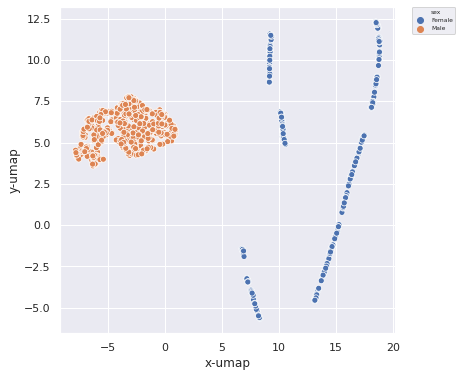

In [19]:
sex_umap_df = sex_umap_df.merge(attrs_df, how='left', left_index=True,
                                right_index=True)

plot_umap_clusters(sex_umap_df, hue_cov='sex')

In [20]:
print(sex_umap_df.loc[(sex_umap_df['x_umap'] > 5) & (sex_umap_df['sex'] == 'Male')].shape)
print(sex_umap_df.loc[(sex_umap_df['x_umap'] < 5) & (sex_umap_df['sex'] == 'Female')].shape)

(0, 137)
(0, 137)


#### double check the age range to make sure no young subjects

In [21]:
attrs_df['age_at_baseline'].describe()

count    853.000000
mean      62.050410
std        9.784223
min       31.000000
25%       56.000000
50%       63.000000
75%       69.000000
max       85.000000
Name: age_at_baseline, dtype: float64

#### drop the know bad samples

In [22]:
# len(set(bad_samples.index) & set(expr_df.index))

In [23]:
# # now drop the know bad samples
# bad_samples.head()
# print(expr_df.shape)
# expr_df = expr_df.loc[~expr_df.index.isin(bad_samples.index)]
# print(expr_df.shape)

#### look at detection rates

In [24]:
print(f'minimun TPM value is {min_expr_value}')

detected_df = expr_df.mask(expr_df < min_expr_value, 0)

# calculate the missing counts from the detected df mask
trait_missing_rates = round(detected_df.isin({0}).sum(0)/detected_df.shape[0], 2)
sample_missing_rates = round(detected_df.isin({0}).sum(1)/detected_df.shape[1], 2)

print(len(trait_missing_rates))
print(trait_missing_rates.mean())
print(len(sample_missing_rates))
print(sample_missing_rates.mean())

minimun TPM value is 1
58294
0.6598396061344486
853
0.659695193434936


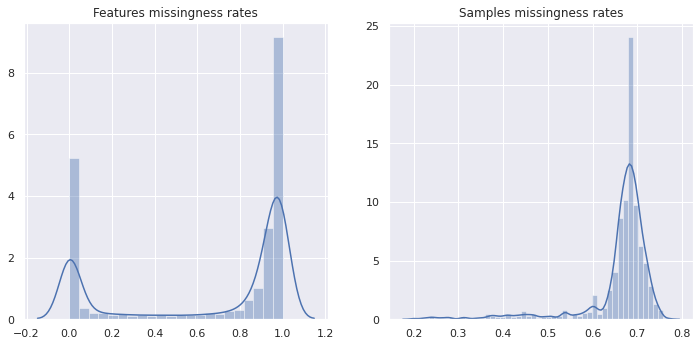

In [25]:
sns.set()
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
sns.distplot(trait_missing_rates.values)
plt.title('Features missingness rates')
plt.subplot(2, 2, 2)
sns.distplot(sample_missing_rates.values)
plt.title('Samples missingness rates')
plt.show()

#### find genes with poor call-rates

In [26]:
bad_call_rates = trait_missing_rates[trait_missing_rates > max_missing_rate]
print(bad_call_rates.shape)
print(bad_call_rates.shape[0]/expr_df.shape[1])

(41123,)
0.7054413833327615


#### add the sample missingness rate as covariate

In [27]:
attrs_df['misrate'] = sample_missing_rates

#### subset df to well detected (wd) features

In [28]:
detected_traits = list(set(expr_df.columns)-set(bad_call_rates.index))
quants_wd_df = expr_df[detected_traits]
print(quants_wd_df.shape)

(853, 17171)


#### recheck call-rates

In [29]:
# see how well each trait is expressed
print(f'minimun TPM value is {min_expr_value}')

detected_df = quants_wd_df.mask(quants_wd_df < min_expr_value, 0)

# calculate the missing counts from the detected df mask
trait_missing_rates = round(detected_df.isin({0}).sum(0)/detected_df.shape[0], 2)
sample_missing_rates = round(detected_df.isin({0}).sum(1)/detected_df.shape[1], 2)

print(len(trait_missing_rates))
print(trait_missing_rates.mean())
print(len(sample_missing_rates))
print(sample_missing_rates.mean())

minimun TPM value is 1
17171
0.03454720167724562
853
0.0347596717467762


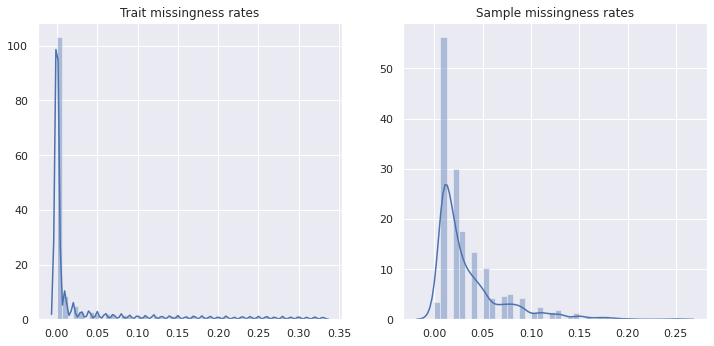

In [30]:
sns.set()
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
sns.distplot(trait_missing_rates.values)
plt.title('Trait missingness rates')
plt.subplot(2, 2, 2)
sns.distplot(sample_missing_rates.values)
plt.title('Sample missingness rates')
plt.show()

#### normalize the traits

In [31]:
%%time

scaledX = preprocessing.quantile_transform(quants_wd_df, axis=0, copy=True,
                                           output_distribution='normal')
traits_qtnorm_df = pd.DataFrame(data=scaledX, columns=quants_wd_df.columns,
                                index=quants_wd_df.index)

/home/gibbsr/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2370: UserWarning: n_quantiles (1000) is greater than the total number of samples (853). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


CPU times: user 36.2 s, sys: 269 ms, total: 36.4 s
Wall time: 36.4 s


#### save the quantile normalized expression matrix

In [32]:
%%time 

traits_qtnorm_df.to_hdf(qtnorm_expr_file, key='expression', mode='w')

CPU times: user 339 ms, sys: 135 ms, total: 474 ms
Wall time: 699 ms


#### take a look at the normalized data

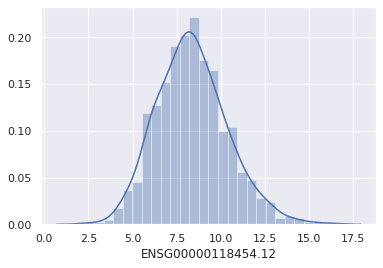

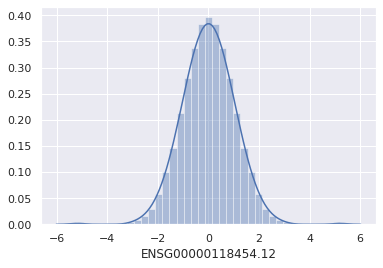

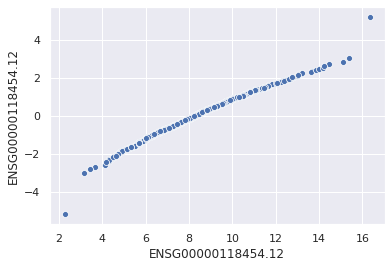

In [33]:
# spot check one of the genes
trait = random.sample(list(quants_wd_df.columns), 1)[0]

sns.distplot(quants_wd_df[trait])
plt.show()
sns.distplot(traits_qtnorm_df[trait])
plt.show()
sns.scatterplot(x=quants_wd_df[trait], y=traits_qtnorm_df[trait])

In [34]:
%%time

umap_df = generate_umap_df_from_df(traits_qtnorm_df)
umap_df = umap_df.merge(attrs_df, how='left', left_index=True, right_index=True)

The dimensions of the umap df and the traits are (853, 2)
CPU times: user 8.6 s, sys: 73.2 ms, total: 8.67 s
Wall time: 8.58 s


#### what are the post normalization umap variable correlated with

                         x_umap    y_umap
misrate               -0.627391 -0.646025
Submitted_Volume__ul_ -0.237184 -0.185414
RIN_Value             -0.176941 -0.430862
Plate_P223            -0.139138  0.008197
Box_7                 -0.139138  0.008197
                                  x_umap    y_umap
Plate_P220                      0.132051 -0.028621
Position                        0.157031  0.170646
Box_20346-J_RNA_1               0.164603  0.018387
Concentration                   0.257799  0.267643
Normalization_Volume__30ng_ul_  0.290468  0.212715
                                                      x_umap    y_umap
misrate                                            -0.627391 -0.646025
RIN_Value                                          -0.176941 -0.430862
_260_280_Ratio                                     -0.082875 -0.217162
Submitted_Volume__ul_                              -0.237184 -0.185414
prodromal_category_Unknown/Not collected as enr... -0.014534 -0.144067
                

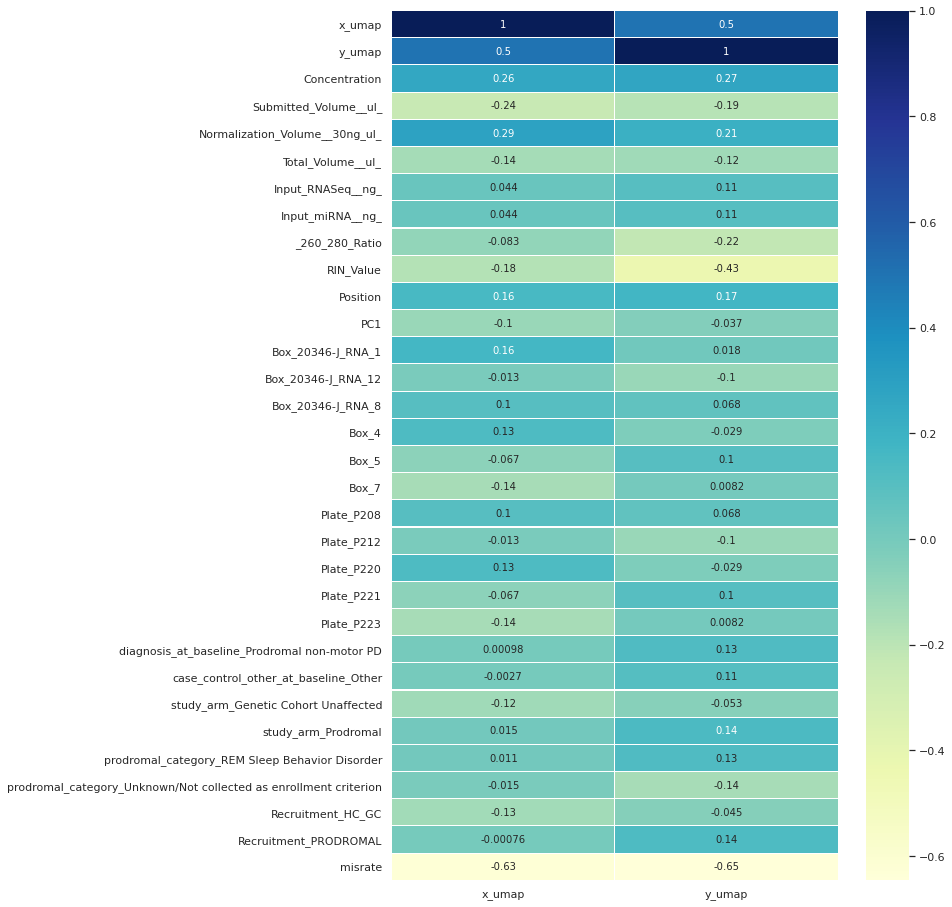

In [35]:
most_x_umap, most_y_umap = plot_corr_heatmap(umap_df, features=['x_umap', 'y_umap'])

misrate RIN_Value


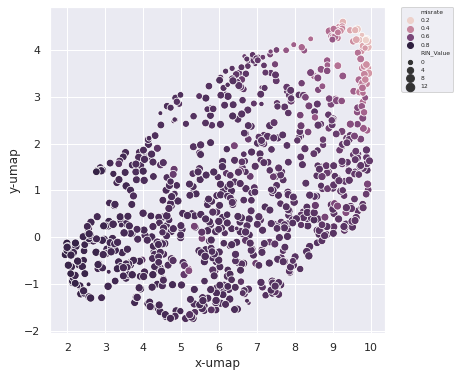

In [36]:
print(most_x_umap, most_y_umap)
plot_umap_clusters(umap_df, hue_cov=most_x_umap, size_cov=most_y_umap)

#### exclude low variance genes from covariate generation

In [37]:
quants_vars = traits_qtnorm_df.var() 
print(quants_vars.describe())
# drop genes within the lower quartile of variance
min_variance = quants_vars.describe()['25%']
# min_variance = quants_vars.describe()['50%']
keep = quants_vars[quants_vars > min_variance]
print(keep.shape)
print(traits_qtnorm_df.shape)
quants_wd_var_df = traits_qtnorm_df[list(keep.index)]
print(quants_wd_var_df.shape)

count    17171.000000
mean         1.129667
std          0.510769
min          1.047109
25%          1.048595
50%          1.048595
75%          1.048595
max          7.600325
dtype: float64
(12878,)
(853, 17171)
(853, 12878)


#### take a look at the data

In [38]:
%%time

umap_df = generate_umap_df_from_df(quants_wd_var_df)
umap_df = umap_df.merge(attrs_df, how='left', left_index=True, right_index=True)

The dimensions of the umap df and the traits are (853, 2)
CPU times: user 6.58 s, sys: 45.3 ms, total: 6.63 s
Wall time: 6.54 s


In [39]:
# calculate the standard z-scores
umap_z_df = umap_df[['x_umap', 'y_umap']].apply(stats.zscore)
print(umap_z_df.describe())

             x_umap        y_umap
count  8.530000e+02  8.530000e+02
mean   1.032076e-07  2.973943e-07
std    1.000587e+00  1.000587e+00
min   -1.790957e+00 -2.136188e+00
25%   -8.228674e-01 -7.207592e-01
50%   -3.336146e-02  1.801601e-01
75%    7.961195e-01  7.488660e-01
max    2.076623e+00  1.760993e+00


#### see what the umaps are correlated with known covariate-wise

                                  x_umap    y_umap
Normalization_Volume__30ng_ul_ -0.299261 -0.186832
Concentration                  -0.281553 -0.247860
Position                       -0.170690 -0.157031
Box_20346-J_RNA_1              -0.151372  0.007083
Plate_P220                     -0.106810  0.046648
                         x_umap    y_umap
Box_7                  0.130238 -0.028617
Total_Volume__ul_      0.139301  0.107780
RIN_Value              0.221927  0.432675
Submitted_Volume__ul_  0.242713  0.163485
misrate                0.682176  0.584305
                                  x_umap    y_umap
Concentration                  -0.281553 -0.247860
Normalization_Volume__30ng_ul_ -0.299261 -0.186832
Position                       -0.170690 -0.157031
study_arm_Prodromal            -0.029358 -0.153910
Recruitment_PRODROMAL          -0.014026 -0.149898
                                                      x_umap    y_umap
prodromal_category_Unknown/Not collected as enr...  0.029358  0.1

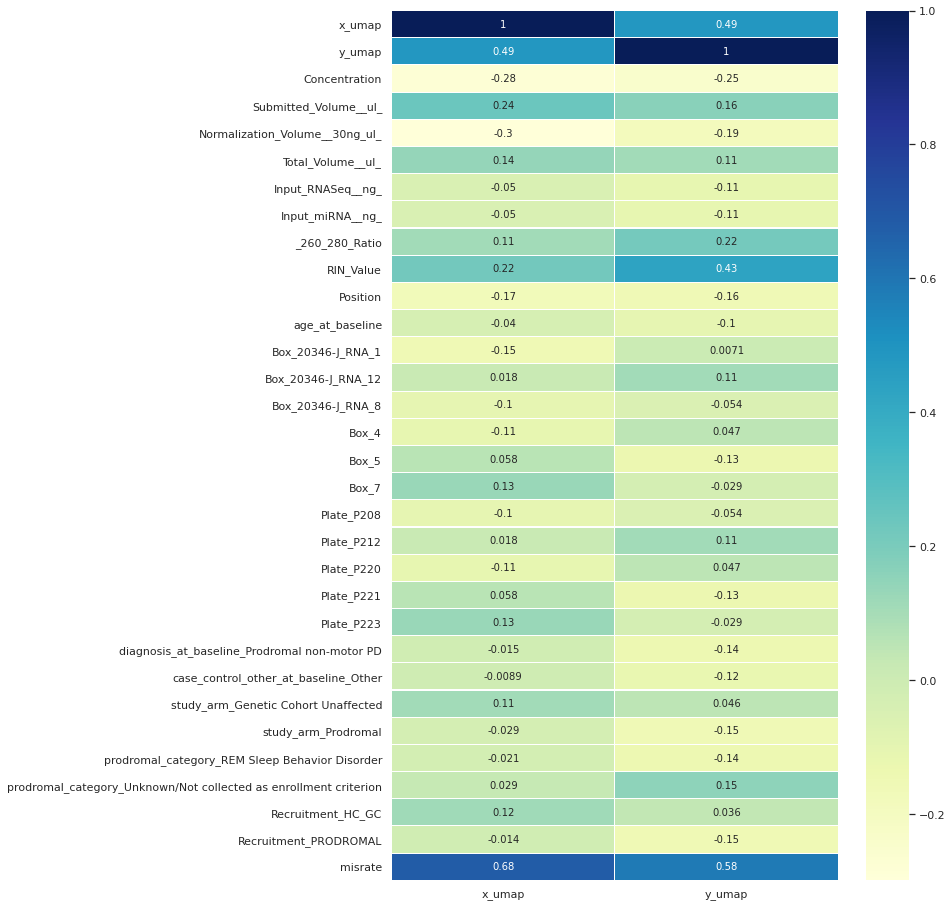

In [40]:
most_x_umap, most_y_umap = plot_corr_heatmap(umap_df, features=['x_umap', 'y_umap'])

misrate RIN_Value


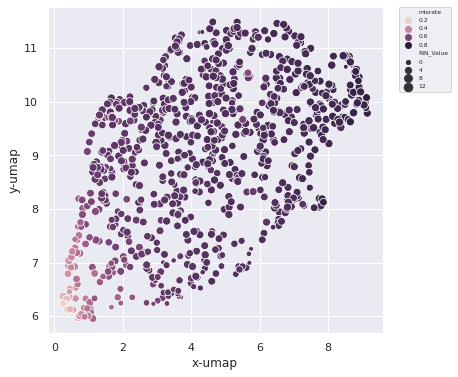

In [41]:
print(most_x_umap, most_y_umap)
plot_umap_clusters(umap_df, hue_cov=most_x_umap, size_cov=most_y_umap)

In [42]:
# with pd.option_context('display.max_seq_items', None):
#     print (umap_df.columns)

#### keep created covars and save them

In [43]:
covs_df = umap_df[['x_umap', 'y_umap']]
covs_df.to_csv(umap_covs_file)

#### covariate adjust the normalized data by the covariates

In [44]:
# check to see in df's have same indices
if not traits_qtnorm_df.index.equals(covs_df.index):
    print('indices are not equal re-index')
    covs_df.reindex(traits_qtnorm_df.index)
    
traits_qtnorm_df.index.equals(covs_df.index)    

True

In [45]:
%%time

residuals_df, cov_scores_df = covariate_residuals(traits_qtnorm_df, covs_df)

#take a peek at the data
print(residuals_df.shape)
print(cov_scores_df.shape)

print(cov_scores_df.head())

(853, 17171)
(17171, 1)
                    score
geneID                   
ENSG00000135722.8   0.612
ENSG00000138381.9   0.501
ENSG00000110768.11  0.624
ENSG00000112667.12  0.292
ENSG00000215160.3   0.714
CPU times: user 22min 43s, sys: 1min 38s, total: 24min 22s
Wall time: 2min 1s


In [46]:
# get a summary of the covariates model scores
cov_scores_df.describe()

,score
count,17171.000000
mean,0.444126
std,0.208899
min,0.000000
25%,0.289500
50%,0.467000
75%,0.608500
max,0.895000


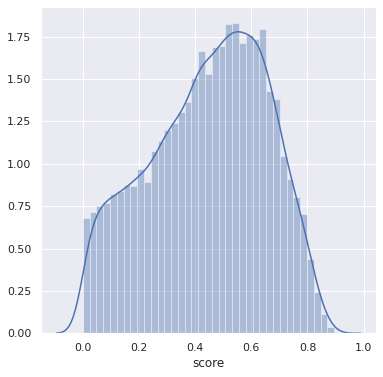

In [47]:
# look at the distribution of covariate model scores, 
# ie get a sense any gene driven by covariates
sns.set()
plt.figure(figsize=(6,6))
sns.distplot(cov_scores_df['score'])
plt.show()

#### save quantile normalized and covariate adjusted data

In [48]:
%%time 

residuals_df.to_hdf(adj_expr_file, key='expression', mode='w')

CPU times: user 169 ms, sys: 101 ms, total: 270 ms
Wall time: 525 ms


#### take a look at the normalized and covariate adjusted data

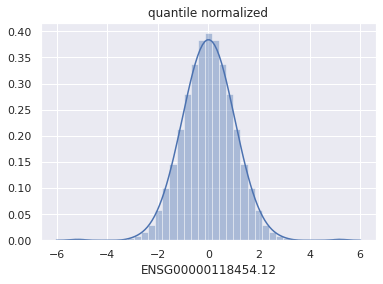

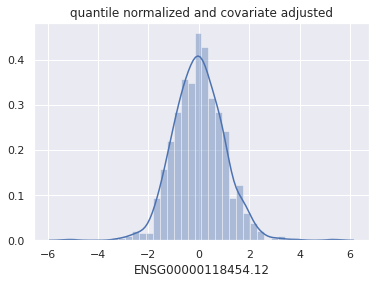

Text(0, 0.5, 'after covariate adjusted')

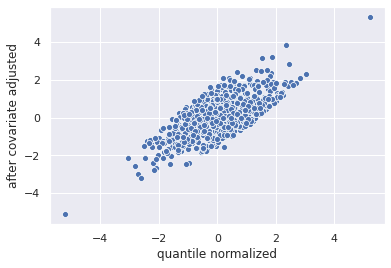

In [49]:
# spot check same gene as before 
sns.distplot(traits_qtnorm_df[trait])
plt.title('quantile normalized')
plt.show()
sns.distplot(residuals_df[trait])
plt.title('quantile normalized and covariate adjusted')
plt.show()
sns.scatterplot(x=traits_qtnorm_df[trait], y=residuals_df[trait])
plt.xlabel('quantile normalized')
plt.ylabel('after covariate adjusted')

                    score
geneID                   
ENSG00000236539.3   0.895
ENSG00000124155.17  0.895


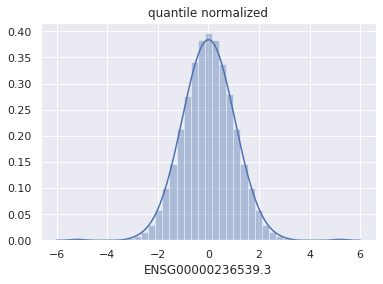

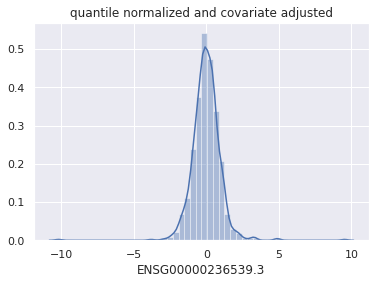

Text(0, 0.5, 'after covariate adjusted')

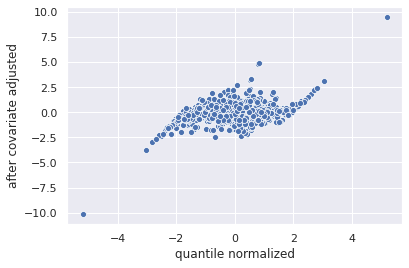

In [50]:
# find gene with largest score
large_adj_trait = cov_scores_df.loc[cov_scores_df['score'] == max(cov_scores_df['score'])]
print(large_adj_trait)
large_adj_traid_id = large_adj_trait.index.values[0]

# spot check same gene as before 

sns.distplot(traits_qtnorm_df[large_adj_traid_id])
plt.title('quantile normalized')
plt.show()
sns.distplot(residuals_df[large_adj_traid_id])
plt.title('quantile normalized and covariate adjusted')
plt.show()
sns.scatterplot(x=traits_qtnorm_df[large_adj_traid_id],
                y=residuals_df[large_adj_traid_id])
plt.xlabel('quantile normalized')
plt.ylabel('after covariate adjusted')

#### what are the post normalization and covariate adjusted umap variables correlated with

In [51]:
%%time

umap_df = generate_umap_df_from_df(residuals_df)
umap_df = umap_df.merge(attrs_df, how='left', left_index=True, right_index=True)

The dimensions of the umap df and the traits are (853, 2)
CPU times: user 7.95 s, sys: 86.2 ms, total: 8.04 s
Wall time: 7.95 s


                                    x_umap    y_umap
Total_Volume__ul_                -0.115704 -0.025058
ethnicity_Not Hispanic or Latino -0.115240  0.012981
Submitted_Volume__ul_            -0.101220 -0.043250
Box_20346-J_RNA_14               -0.087115 -0.009612
Plate_P214                       -0.087115 -0.009612
                     x_umap    y_umap
Input_RNASeq__ng_  0.117018  0.000659
Input_miRNA__ng_   0.117018  0.000659
Box_5              0.150402 -0.120466
Plate_P221         0.150402 -0.120466
misrate            0.404975  0.123484
                                       x_umap    y_umap
Recruitment_HC_GC                    0.058774 -0.132732
study_arm_Genetic Cohort Unaffected  0.062833 -0.131890
Box_5                                0.150402 -0.120466
Plate_P221                           0.150402 -0.120466
case_control_other_latest_Control    0.028260 -0.092128
                   x_umap    y_umap
Box_4            0.022845  0.103335
Plate_P220       0.022845  0.103335
sex_Male  

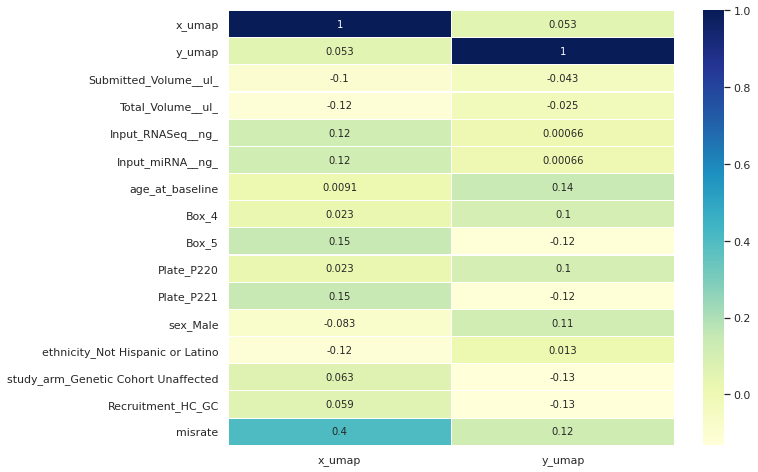

In [52]:
most_x_umap, most_y_umap = plot_corr_heatmap(umap_df, features=['x_umap', 'y_umap'])

misrate age_at_baseline


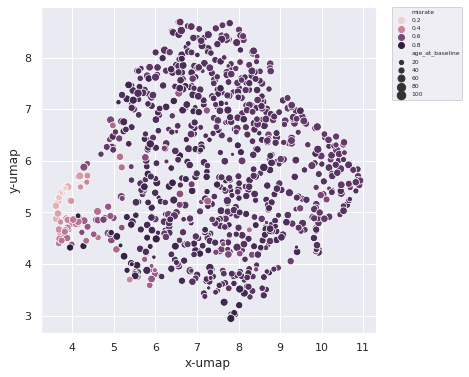

In [53]:
print(most_x_umap, most_y_umap)
plot_umap_clusters(umap_df, hue_cov=most_x_umap, size_cov=most_y_umap)

#### save the final prepped expression data as plink2 pheno files

In [54]:
%%time

def write_chrom_pheno_data(this_df, chrom, gencode_df, file_name, id_map):
    chrom_gencode_df =  gencode_df.loc[gencode_df['seqname'] == f'chr{chrom}', ['gene_id']]
    chrom_genes_present = list(set(chrom_gencode_df['gene_id']) & set(this_df.columns))
    chrom_df = this_df[chrom_genes_present].copy()
    # plink will expect FID and IID columns go ahea and add here
    chrom_df = chrom_df.merge(id_map, how='left', left_index=True, right_index=True)
    chrom_df.insert( 0, column="FID", value=chrom_df['wgsid'])
    chrom_df.insert( 1, column="IID", value=chrom_df['wgsid'])
    chrom_df.drop(columns=['wgsid', 'rnaid'], inplace=True)
    print(f'chr{chrom} {chrom_df.shape}')
    chrom_df.to_csv(file_name, index=False, header=True, sep='\t')


#go ahead and subset gencode annots to just thos present in data
gencode_present_df = gencode_df.loc[gencode_df['gene_id'].isin(residuals_df.columns)]
job_threads = []
for chrom in autosomes:
    out_file = f'{expr_dir}/{cohort_build}.chr{chrom}.pheno'
    this_thread = threading.Thread(target=write_chrom_pheno_data,
                                   args=(residuals_df, chrom, gencode_present_df, out_file, id_map))
    job_threads.append(this_thread)
    this_thread.start()

for job_thread in job_threads:
    job_thread.join()    

chr13 (853, 326)
chr5 (853, 765)
chr18 (853, 298)
chr1 (853, 1685)
chr6 (853, 878)
chr9 (853, 659)
chr10 (853, 636)
chr8 (853, 609)
chr4 (853, 653)
chr2 (853, 1173)
chr19 (853, 1085)
chr21 (853, 200)
chr20 (853, 416)
chr3 (853, 949)
chr16 (853, 804)
chr11 (853, 907)
chr22 (853, 398)
chr15 (853, 613)
chr7 (853, 876)
chr14 (853, 708)
chr17 (853, 1060)
chr12 (853, 974)
CPU times: user 45.8 s, sys: 4.25 s, total: 50 s
Wall time: 47.3 s
